<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Load Data</a></span></li></ul></li><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Train test split</a></span></li><li><span><a href="#Classification-modeling" data-toc-modified-id="Classification-modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Classification modeling</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Ridge-Classifer" data-toc-modified-id="Ridge-Classifer-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ridge Classifer</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Gradient-Boosting" data-toc-modified-id="Gradient-Boosting-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Gradient Boosting</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#GNB" data-toc-modified-id="GNB-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>GNB</a></span></li></ul></li><li><span><a href="#ROC-AUC-Curve" data-toc-modified-id="ROC-AUC-Curve-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ROC AUC Curve</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
%matplotlib inline
sns.set(style = "whitegrid")
sns.set_palette("icefire")
plt.rcParams['figure.figsize'] = (9, 6)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings(action="ignore")

In [87]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, recall_score, roc_curve
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight

## Load Data

In [3]:
providers = joblib.load('providers_last.pkl')
providers = providers.set_index('Provider')
print(providers.shape)
providers.head()

(5410, 87)


,PotentialFraud,Perc_Outpatient,DualPatientProvider,Perc_DualPatientType,Ratio_ClaimsPerPatient,Ratio_ClaimsPerAttPhys,Perc_ClaimsPerTopFraudState,Perc_HasTop5AdmtCode,Perc_MultHospAttPhys,Perc_MultHospOperPhys,Perc_MultHospOtherPhys,IP_Perc_Duplicates,IP_Count_UniquePatients,IP_Count_UniqueState,IP_Mean_AgeAtClaim,IP_Perc_HasDied,IP_Perc_GenderZero,IP_Perc_RaceOne,IP_Perc_RaceTwo,IP_Perc_RaceThree,IP_Mean_NumChronicConds,IP_Perc_Alzheimers_Chronic,IP_Perc_Cancer_Chronic,IP_Perc_Depression_Chronic,IP_Perc_Diabetes_Chronic,IP_Perc_HeartFailure_Chronic,IP_Perc_IschemicHeart_Chronic,IP_Perc_KidneyDisease_Chronic,IP_Perc_ObstrPulmonary_Chronic,IP_Perc_Osteoporosis_Chronic,IP_Perc_RheumatoidArthritis_Chronic,IP_Perc_Stroke_Chronic,IP_Perc_HasRenalDisease,IP_Mean_ClaimDuration,IP_Mean_AdmitDuration,IP_Mean_NoOfMonths_PartACov,IP_Mean_NoOfMonths_PartBCov,IP_Mean_ClaimCost,IP_Mean_DailyClaimCost,IP_Mean_DeductibleAmtPaid,IP_Mean_InscClaimAmtReimbursed,IP_Mean_InsReimbursementRatio,IP_Mean_AnnualDeductibleAmt,IP_Mean_AnnualReimbursementAmt,IP_Perc_No_ProcCode,IP_Perc_HasAllPhys,IP_Perc_HasNoPhys,IP_Perc_MultHosp,OP_Perc_Duplicates,OP_Count_UniquePatients,OP_Count_UniqueState,OP_Mean_AgeAtClaim,OP_Perc_HasDied,OP_Perc_GenderZero,OP_Perc_RaceOne,OP_Perc_RaceTwo,OP_Perc_RaceThree,OP_Mean_NumChronicConds,OP_Perc_Alzheimers_Chronic,OP_Perc_Cancer_Chronic,OP_Perc_Depression_Chronic,OP_Perc_Diabetes_Chronic,OP_Perc_HeartFailure_Chronic,OP_Perc_IschemicHeart_Chronic,OP_Perc_KidneyDisease_Chronic,OP_Perc_ObstrPulmonary_Chronic,OP_Perc_Osteoporosis_Chronic,OP_Perc_RheumatoidArthritis_Chronic,OP_Perc_Stroke_Chronic,OP_Perc_HasRenalDisease,OP_Mean_ClaimDuration,OP_Mean_NoOfMonths_PartACov,OP_Mean_NoOfMonths_PartBCov,OP_Mean_ClaimCost,OP_Mean_DailyClaimCost,OP_Mean_DeductibleAmtPaid,OP_Mean_InscClaimAmtReimbursed,OP_Mean_InsReimbursementRatio,OP_Mean_AnnualDeductibleAmt,OP_Mean_AnnualReimbursementAmt,OP_Perc_No_DiagCode,OP_Perc_HasAllPhys,OP_Perc_HasNoPhys,OP_Perc_MultHosp,Patient_Attphy_Ratio,Patient_Operphy_Ratio,Patient_Otherphy_Ratio
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,0,0.800000,1.0,0.400000,1.041667,1.785714,0.0,0.040000,0.240000,0.040000,0.000000,0.000000,5.0,1.0,77.600000,0.000000,0.400000,1.000000,0.000000,0.0,6.000000,0.400000,0.200000,0.800000,0.800000,0.800000,0.800000,0.800000,0.400000,0.000000,0.600000,0.400000,0.400000,6.000000,6.000000,12.000000,12.000000,20468.000000,4077.360000,1068.0,19400.000000,0.878279,897.120000,17606.000000,0.600000,0.2,0.0,0.160000,0.550000,19.0,1.0,77.950000,0.000000,0.350000,0.800000,0.200000,0.000000,5.450000,0.650000,0.200000,0.250000,0.850000,0.750000,0.950000,0.650000,0.400000,0.300000,0.250000,0.200000,0.300000,1.550000,12.000000,12.000000,382.000000,307.000000,0.000000,382.000000,1.000000,463.920000,2615.200000,0.000000,0.050000,0.000000,0.920000,1.714286,4.800000,3.000000
PRV51003,1,0.530303,1.0,0.500000,1.128205,3.000000,0.0,0.060606,0.007576,0.000000,0.000000,0.016129,53.0,3.0,69.935484,0.016129,0.338710,0.790323,0.209677,0.0,4.919355,0.516129,0.112903,0.403226,0.790323,0.580645,0.887097,0.629032,0.370968,0.209677,0.306452,0.112903,0.274194,6.161290,6.161290,11.806452,11.806452,10309.935484,2384.941628,1068.0,9241.935484,0.821059,931.424242,7568.181818,0.370968,0.0,0.0,0.045455,0.357143,66.0,3.0,68.371429,0.000000,0.471429,0.828571,0.157143,0.000000,4.214286,0.342857,0.042857,0.414286,0.728571,0.628571,0.814286,0.357143,0.257143,0.285714,0.271429,0.071429,0.171429,3.357143,11.828571,11.928571,467.714286,336.440760,1.000000,466.714286,0.994032,737.121212,2678.181818,0.000000,0.057143,0.000000,0.818182,2.659091,16.714286,5.318182
PRV51004,0,1.000000,0.0,0.208054,1.079710,3.921053,0.0,0.013423,0.167785,0.013423,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

# Train test split

In [4]:
# Separate input features (X) and target variable (y)
y = providers['PotentialFraud']
X = providers.drop('PotentialFraud', axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

# Classification modeling

In [6]:
# Stratified Cross Validation needs to be applied
skf = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)

In [7]:
# Apply Scaling
scaler = MinMaxScaler()
X_train_stan = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_stan = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [8]:
# Model evaluation metric: Recall score
def eval_model(model, best_model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    print(model,'score')
    print('-'*30)
    print('Train: recall score:', round(recall_score(y_train, best_model.predict(X_train)),5))
    print('Test: recall score:', round(recall_score(y_test, best_model.predict(X_test)),5))
    print(' ')
    print("Train Test Confusion Matrix")
    print('-'*30)
    print('Train Set')
    print(confusion_matrix(y_train, best_model.predict(X_train)))
    print('Test Set')
    print(confusion_matrix(y_test, best_model.predict(X_test)))

## Logistic Regression

In [9]:
logistic = LogisticRegression(random_state = 0, solver="liblinear", penalty = 'l1', class_weight = 'balanced')

In [15]:
param_grid = [{'C': np.logspace(-3,1,100)}]
logisticcv = GridSearchCV(logistic, param_grid = param_grid, scoring = 'recall', cv = skf)
para_search = logisticcv.fit(X_train_stan, y_train)
best_logistic = para_search.best_estimator_
print('Best estimator:', best_logistic)

Best estimator: LogisticRegression(C=0.07924828983539177, class_weight='balanced', penalty='l1',
                   random_state=0, solver='liblinear')


In [16]:
eval_model('Logistic Regression', best_logistic, X_train_stan, X_test_stan, y_train, y_test)

Logistic Regression score
------------------------------
Train: recall score: 0.91808
Test: recall score: 0.91447
 
Train Test Confusion Matrix
------------------------------
Train Set
[[2579  854]
 [  29  325]]
Test Set
[[1118  353]
 [  13  139]]


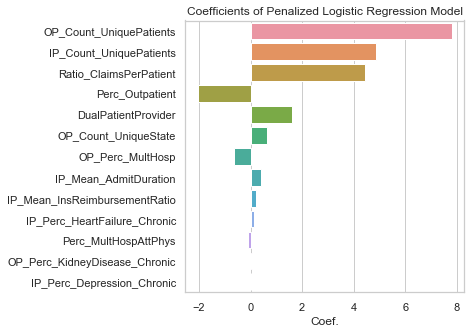

In [17]:
logistic_coef = pd.DataFrame(best_logistic.coef_.T, index = X_train.columns).rename(columns = {0:"Coef."})
logistic_coef = logistic_coef.reindex(logistic_coef["Coef."].abs().sort_values(ascending = False).index)
logistic_coef = logistic_coef.reset_index()
plt.figure(figsize = (5,5))
sns.barplot(data = logistic_coef[logistic_coef['Coef.'] != 0], x = 'Coef.', y = 'index');
plt.title('Coefficients of Penalized Logistic Regression Model');
plt.ylabel('');

## Ridge Classifer

In [18]:
logistic_coef = logistic_coef.reset_index()
notimportant = logistic_coef[logistic_coef['Coef.'].abs() == 0]['index'].tolist()

In [19]:
# Reset the dataset with selective columns
X_train_reduced = X_train_stan.iloc[:,~X_train_stan.columns.isin(notimportant)]
X_test_reduced = X_test_stan.iloc[:,~X_test_stan.columns.isin(notimportant)]

In [20]:
ridge = RidgeClassifier(random_state = 0, class_weight = 'balanced')

In [34]:
param_grid = [{'alpha': np.logspace(-5,-2,100)}]
ridgecv = GridSearchCV(ridge, param_grid = param_grid, scoring = 'recall', cv = skf)
para_search = ridgecv.fit(X_train_reduced, y_train)
best_ridge = para_search.best_estimator_
print('Best estimator:', best_ridge)

Best estimator: RidgeClassifier(alpha=1e-05, class_weight='balanced', random_state=0)


In [35]:
eval_model('Ridge Classifier', best_ridge, X_train_reduced, X_test_reduced, y_train, y_test)

Ridge Classifier score
------------------------------
Train: recall score: 0.92938
Test: recall score: 0.91447
 
Train Test Confusion Matrix
------------------------------
Train Set
[[2590  843]
 [  25  329]]
Test Set
[[1135  336]
 [  13  139]]


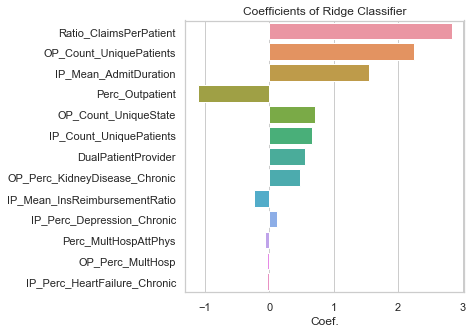

In [36]:
ridge_coef = pd.DataFrame(best_ridge.coef_.T, index = X_train_reduced.columns).rename(columns = {0:"Coef."})
ridge_coef = ridge_coef.reindex(ridge_coef["Coef."].abs().sort_values(ascending = False).index)
ridge_coef = ridge_coef.reset_index()
plt.figure(figsize = (5,5))
sns.barplot(data = ridge_coef, x = 'Coef.', y = 'index');
plt.title('Coefficients of Ridge Classifier');
plt.ylabel('');

In [ ]:
# joblib.dump(best_ridge,'best_ridge.pkl')

## Random Forest

In [37]:
randomForest = RandomForestClassifier(random_state = 0, 
                                      max_features = 'auto', 
                                      max_depth = 3, 
                                      class_weight = 'balanced_subsample')
grid_para_forest = {'n_estimators': range(480,600,10),
                    'min_samples_split': range(5,14),
                    'min_samples_leaf' : range(2,9)}

In [42]:
grid_search_forest = GridSearchCV(randomForest,
                                        grid_para_forest,
                                        cv=skf, 
                                        n_jobs = 5, 
                                        verbose = 1,
                                        return_train_score = True,
                                        scoring = 'recall')
# Fit Random Forest 
para_search = grid_search_forest.fit(X_train, y_train)

# Save the best estimator
best_rf = para_search.best_estimator_
print('Best parameters:', para_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   33.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:  2.6min finished


Best parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 500}


In [43]:
# rf = RandomForestClassifier(random_state = 0,
#                            max_features = 'auto',
#                            class_weight = 'balanced',
#                            n_estimators = 500,
#                            max_depth = 5,
#                            min_samples_split = 15,
#                            min_samples_leaf = 15)
# rf.fit(X_train, y_train)

In [44]:
eval_model('Random Forest', best_rf, X_train, X_test, y_train, y_test)

Random Forest score
------------------------------
Train: recall score: 0.91243
Test: recall score: 0.90132
 
Train Test Confusion Matrix
------------------------------
Train Set
[[2823  610]
 [  31  323]]
Test Set
[[1232  239]
 [  15  137]]


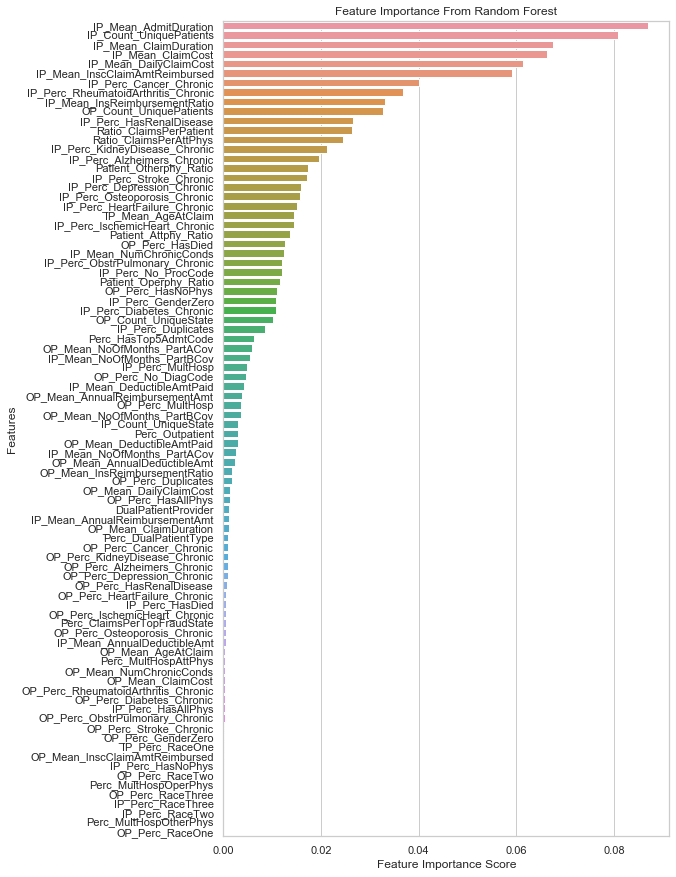

In [45]:
sorted_importance = sorted(zip(X_train.columns, best_rf.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (8,15))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance From Random Forest');
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');

In [ ]:
# joblib.dump(best_rf,'best_rf.pkl')

## Gradient Boosting

In [47]:
sample_weight = compute_sample_weight(class_weight = 'balanced', y = y_train)

In [51]:
gb = GradientBoostingClassifier(random_state = 0, max_features = 'auto', max_depth = 2)
grid_para_gb = {'n_estimators': range(250,350,10),
                'learning_rate': np.logspace(-3,0,50),
                    'min_samples_split': range(11,25),
                    'min_samples_leaf' : range(11,25)}

In [52]:
grid_search_gb = RandomizedSearchCV(gb, 
                                    grid_para_gb, 
                                    cv= skf, 
                                    n_jobs = 5, 
                                    verbose = 1,
                                    return_train_score = True,
                                    scoring = 'recall')
para_search = grid_search_gb.fit(X_train, y_train, sample_weight = sample_weight)
best_gb = para_search.best_estimator_
print('Best parameters:', para_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   41.6s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   51.3s finished


Best parameters: {'n_estimators': 340, 'min_samples_split': 19, 'min_samples_leaf': 14, 'learning_rate': 0.0071968567300115215}


In [53]:
# gb = GradientBoostingClassifier(random_state = 0, 
#                                 max_features = 'auto',
#                                 n_estimators = 300,
#                                 learning_rate = 0.01,
#                                 max_depth = 2,
#                                 min_samples_leaf = 15,
#                                 min_samples_split = 15)
# gb.fit(X_train,y_train, sample_weight = sample_weight)

In [54]:
eval_model('Gradient Boosting', best_gb, X_train, X_test, y_train, y_test)

Gradient Boosting score
------------------------------
Train: recall score: 0.92655
Test: recall score: 0.92105
 
Train Test Confusion Matrix
------------------------------
Train Set
[[2956  477]
 [  26  328]]
Test Set
[[1285  186]
 [  12  140]]


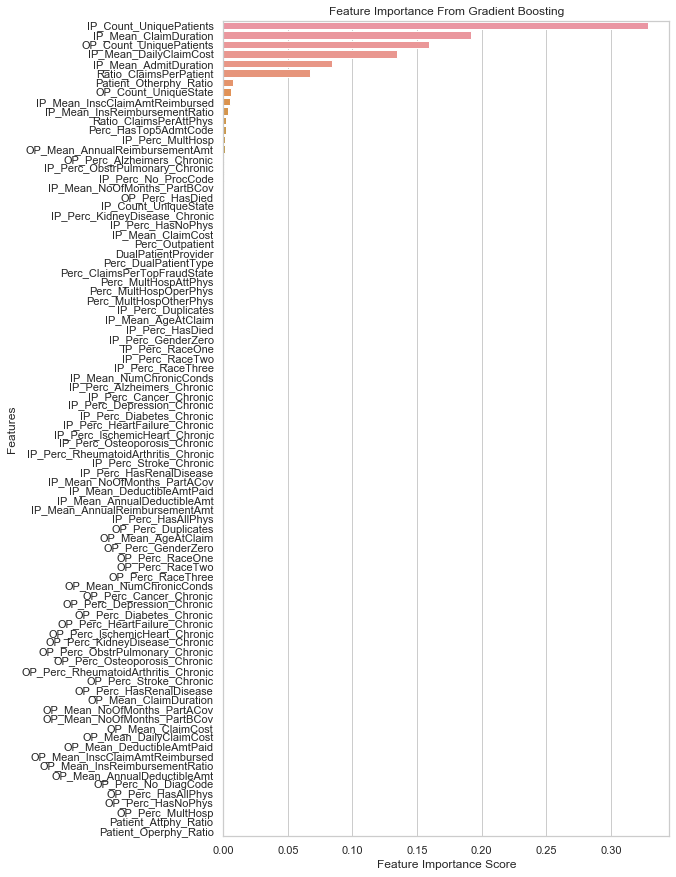

In [56]:
sorted_importance = sorted(zip(X_train.columns, best_gb.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (8,15))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance From Gradient Boosting');
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');

In [ ]:
# joblib.dump(best_gb,'best_gb.pkl')

## SVM

In [66]:
svm = SVC(random_state = 0, class_weight = 'balanced')
grid_para_svm = {'C':np.logspace(-2,1,60)}

In [67]:
grid_search_svm = GridSearchCV(svm, 
                                    grid_para_svm, 
                                    cv= skf, 
                                    n_jobs = 5, 
                                    verbose = 1,
                                    return_train_score = True,
                                    scoring = 'recall')
para_search = grid_search_svm.fit(X_train_stan, y_train)
best_svm = para_search.best_estimator_
print('Best parameters:', para_search.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   44.9s
[Parallel(n_jobs=5)]: Done 300 out of 300 | elapsed:  1.1min finished


Best parameters: {'C': 0.5355666917706899}


In [68]:
eval_model('SVM', best_svm, X_train_stan, X_test_stan, y_train, y_test)

SVM score
------------------------------
Train: recall score: 0.9209
Test: recall score: 0.92105
 
Train Test Confusion Matrix
------------------------------
Train Set
[[2584  849]
 [  28  326]]
Test Set
[[1125  346]
 [  12  140]]


In [ ]:
# joblib.dump(best_svm, 'best_svm.pkl')

## GNB

In [69]:
gnb = GaussianNB()
grid_para_gnb = {'var_smoothing': np.logspace(-3,0,100)}

In [70]:
grid_search_gnb = GridSearchCV(gnb, 
                                    grid_para_gnb, 
                                    cv= skf, 
                                    n_jobs = 5, 
                                    verbose = 1,
                                    return_train_score = True,
                                    scoring = 'recall')
para_search = grid_search_gnb.fit(X_train_stan, y_train)
best_gnb = para_search.best_estimator_
print('Best parameters:', para_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s


Best parameters: {'var_smoothing': 0.03511191734215131}


[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:    2.9s finished


In [71]:
eval_model('GNB', best_gnb, X_train_stan, X_test_stan, y_train, y_test)

GNB score
------------------------------
Train: recall score: 0.88418
Test: recall score: 0.86842
 
Train Test Confusion Matrix
------------------------------
Train Set
[[2341 1092]
 [  41  313]]
Test Set
[[1044  427]
 [  20  132]]


In [ ]:
# joblib.dump(best_gnb, 'best_gnb.pkl')

# ROC AUC Curve

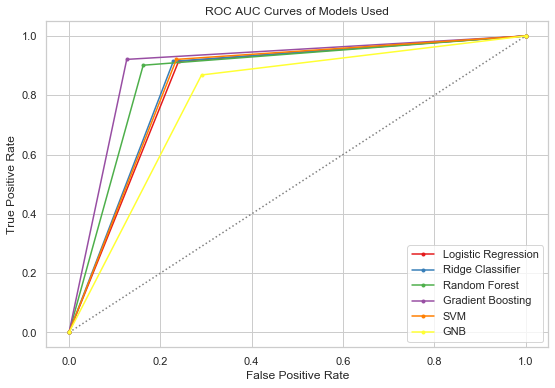

In [90]:
sns.set_palette('Set1')
random_probs = [0 for i in range(len(y_test))]
fpr, tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, best_logistic.predict(X_test_stan))
ridge_fpr, ridge_tpr, _ = roc_curve(y_test, best_ridge.predict(X_test_reduced))
rf_fpr, rf_tpr, _ = roc_curve(y_test, best_rf.predict(X_test))
gb_fpr, gb_tpr, _ = roc_curve(y_test, best_gb.predict(X_test))
svm_fpr, svm_tpr, _ = roc_curve(y_test, best_svm.predict(X_test_stan))
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, best_gnb.predict(X_test_stan))


# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle = ':', color = 'gray');
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic Regression');
plt.plot(ridge_fpr, ridge_tpr, marker='.', label='Ridge Classifier');
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest');
plt.plot(gb_fpr, gb_tpr, marker='.', label='Gradient Boosting');
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM');
plt.plot(gnb_fpr, gnb_tpr, marker='.', label='GNB');

plt.legend();
plt.title('ROC AUC Curves of Models Used')
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');